# Modelling

The main objectives for this notebook are:
* To develop a model that will satisfiy our modelling objective
* To properly evaluate the developed model
* To have a trained model ready for deployment

The skills that you need to showcase:
* Your knowledge on how to properly evaluate an ML model (train/val/test, leaking, importances, etc.)
* Your ML knoweldge - in particular for HP tuning

## How to stand out?
1. Have a proper baseline
2. Perform post-modellign steps - threshold selection, explainability, false positives / false negatives
3. Use something like MLFlow for experiment tracking
4. Build an ML training pipeline using Kedro/ZenML/Metaflow/etc

**Don't spend too much time on hyper-parameter tuning!!!**

In [29]:
import os
import sys
import warnings

import joblib
import mlflow
import numpy as np
import plotly.express as px
import polars as pl
import shap
from optuna.integration.mlflow import MLflowCallback
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

In [4]:
# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

from ml import evaluate_thresholds, tune_hgbt

In [5]:
warnings.filterwarnings("ignore")
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("api_anomaly")
mlflow.sklearn.autolog(disable=True)

## Read Data

In [6]:
data = pl.read_parquet('../data/supervised_clean_data_w_features.parquet')
data.sample(3)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,is_anomaly,max_global_source_degrees,avg_global_source_degrees,min_global_dest_degrees,std_local_source_degrees,max_global_dest_degrees,min_global_source_degrees,std_global_source_degrees,n_connections,avg_global_dest_degrees
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,bool,u32,f64,u32,f64,u32,u32,f64,u32,f64
1067,"""08fb6c52-6c0e-…",0.000024,0.020958,3.242718,1,"""default""",105.0,103.0,7.0,"""F""","""normal""",false,596,387.777778,114,0.527046,1151,68,174.045811,9,928.444444
117,"""a97b474e-0149-…",0.027153,0.014895,39.37037,10391,"""default""",270.0,162.0,95.0,"""E""","""normal""",false,32071,5943.506494,94,6.308133,22416,119,8106.829538,308,6975.301948
637,"""5cf794ea-ca9f-…",0.004493,0.029041,60.396825,2052,"""default""",130.0,126.0,221.0,"""E""","""normal""",false,32071,4996.244186,4,12.753191,22416,9,7920.270224,774,5560.30491


## Data Processing for Modelling

Doing initial modelling, I've noticed that we can perfectly prdict outliers using the provided features which is not surprising - it's generally quite easy to replicate the results of unsupervised models in a supervised way. Hence, the modelling goal for this project has shifted from <br><br> `To develop a supervised model to classify behaviour into normal and anomalous` <br><br> to <br><br>`To develop a supervised model using the engineered features to classify behaviour into normal and anomalous` 

In [7]:
label = "is_anomaly"
numerical_features = [
    "max_global_source_degrees",
    "avg_global_source_degrees",
    "min_global_dest_degrees",
    "std_local_source_degrees",
    "max_global_dest_degrees",
    "min_global_source_degrees",
    "std_global_source_degrees",
    "n_connections",
    "avg_global_dest_degrees",
]

data = data.filter(pl.col('ip_type') == 'default').select([label] + numerical_features) # 
data.sample(3)

is_anomaly,max_global_source_degrees,avg_global_source_degrees,min_global_dest_degrees,std_local_source_degrees,max_global_dest_degrees,min_global_source_degrees,std_global_source_degrees,n_connections,avg_global_dest_degrees
bool,u32,f64,u32,f64,u32,u32,f64,u32,f64
true,10404,2099.7,343,0.0,22416,336,3535.581488,10,4830.1
true,32071,8481.84375,594,1.431219,22416,45,10669.415935,32,9501.5
false,32071,6550.306977,9,6.979811,22416,9,9576.245138,215,7012.967442


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data[numerical_features], data[label].to_list(), test_size=0.2)

In [9]:
print("Train shape: ", X_train.shape)
print("Test shape::", X_test.shape)

Train shape:  (1233, 9)
Test shape:: (309, 9)


## Baseline
Before building a model, we need to understand whether the problem can be solved without using ML. 

In [10]:
from sklearn.metrics import f1_score

heuristic_f1_scores = []
possible_values = X_train['n_connections'].sort().unique().to_list()
for v in possible_values:
    heuristic_pred = X_test.select(pl.col('n_connections') <= v).to_pandas()
    heuristic_f1_scores.append(f1_score(y_test, heuristic_pred))

In [11]:
px.line(
    x=possible_values, 
    y=heuristic_f1_scores, 
    labels={
        "x": "Number of Connections Threshold",
        "y": "F1 Score",
    },
    title='F1 Score for Heuristic Rule'
)

**Insights**
* The optimal number of connections to set as threshold is 19
* Heuristic rule can achive the F1 score of 0.72

## Machine Learning

### Base Model

In [12]:
with mlflow.start_run(run_name='GBT_baseline'):
    params = {
        "learning_rate": 0.1,
        "max_iter": 100,
        "max_leaf_nodes": 31,
        "max_depth": None,
        "l2_regularization": 0,
    }

    mlflow.set_tag("model_name", "HGBT")
    mlflow.log_params(params)

    gbt = HistGradientBoostingClassifier(**params)
    
    roc_auc = cross_val_score(gbt, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print('ROC AUC (avg 5-fold):', roc_auc)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(gbt, "gbt_models")

ROC AUC (avg 5-fold): 0.9923183913032844


**Observations**
* The ROC AUC achieved by the baseline model has very high ROC AUC score of 0.99

**Insights**
* This indicates either target leakage or that the task is very simple
* Given that we don't know how the target was created, we can assume that the data set creates have used some simple anomaly detection methods

**Impact**
* We don't need to do hyperparameter tuning because the task is too simple

### Tuned Model

In [14]:
mlflc = MLflowCallback(
    tracking_uri="sqlite:///mlflow.db",
    metric_name="roc auc",
)

best_trial = tune_hgbt(20, mlflc, X_train, y_train)

[I 2024-03-10 13:52:48,126] A new study created in memory with name: hgbt_tuning
[I 2024-03-10 13:52:49,039] Trial 0 finished with value: 0.9875830908835699 and parameters: {'max_iter': 40, 'max_leaf_nodes': 20, 'max_depth': 8, 'l2_regularization': 7.6587497096365915}. Best is trial 0 with value: 0.9875830908835699.


ROC AUC (avg 5-fold): 0.9875830908835699


[I 2024-03-10 13:52:51,141] Trial 1 finished with value: 0.9912997075183885 and parameters: {'max_iter': 97, 'max_leaf_nodes': 28, 'max_depth': 6, 'l2_regularization': 2.313039760454214}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9912997075183885


[I 2024-03-10 13:52:52,413] Trial 2 finished with value: 0.9911352550667216 and parameters: {'max_iter': 59, 'max_leaf_nodes': 31, 'max_depth': 6, 'l2_regularization': 1.9230688723345435}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9911352550667216


[I 2024-03-10 13:52:53,783] Trial 3 finished with value: 0.9911990257347663 and parameters: {'max_iter': 60, 'max_leaf_nodes': 17, 'max_depth': 9, 'l2_regularization': 1.5261605593575844}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9911990257347663


[I 2024-03-10 13:52:54,664] Trial 4 finished with value: 0.9877891545734213 and parameters: {'max_iter': 90, 'max_leaf_nodes': 10, 'max_depth': 3, 'l2_regularization': 4.091495863483959}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9877891545734213


[I 2024-03-10 13:52:55,798] Trial 5 finished with value: 0.990381244277707 and parameters: {'max_iter': 79, 'max_leaf_nodes': 14, 'max_depth': 4, 'l2_regularization': 4.390663128967951}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.990381244277707


[I 2024-03-10 13:52:58,169] Trial 6 finished with value: 0.9910777490134528 and parameters: {'max_iter': 98, 'max_leaf_nodes': 29, 'max_depth': 7, 'l2_regularization': 5.361210364747343}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9910777490134528


[I 2024-03-10 13:52:58,483] Trial 7 finished with value: 0.9776154028972748 and parameters: {'max_iter': 13, 'max_leaf_nodes': 24, 'max_depth': 5, 'l2_regularization': 3.0299728713513363}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9776154028972748


[I 2024-03-10 13:52:58,750] Trial 8 finished with value: 0.9444193700346979 and parameters: {'max_iter': 31, 'max_leaf_nodes': 28, 'max_depth': 2, 'l2_regularization': 3.8014451922766836}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9444193700346979


[I 2024-03-10 13:53:01,139] Trial 9 finished with value: 0.9911974519380561 and parameters: {'max_iter': 92, 'max_leaf_nodes': 24, 'max_depth': 9, 'l2_regularization': 4.83174158759685}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9911974519380561


[I 2024-03-10 13:53:03,423] Trial 10 finished with value: 0.9910836972738226 and parameters: {'max_iter': 73, 'max_leaf_nodes': 25, 'max_depth': 10, 'l2_regularization': 0.09967589857552861}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9910836972738226


[I 2024-03-10 13:53:04,893] Trial 11 finished with value: 0.9912986162286088 and parameters: {'max_iter': 57, 'max_leaf_nodes': 18, 'max_depth': 7, 'l2_regularization': 0.23522051570486702}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9912986162286088


[I 2024-03-10 13:53:05,796] Trial 12 finished with value: 0.9893387913772955 and parameters: {'max_iter': 34, 'max_leaf_nodes': 19, 'max_depth': 6, 'l2_regularization': 0.07381878338188352}. Best is trial 1 with value: 0.9912997075183885.


ROC AUC (avg 5-fold): 0.9893387913772955


[I 2024-03-10 13:53:07,698] Trial 13 finished with value: 0.9917988177383903 and parameters: {'max_iter': 74, 'max_leaf_nodes': 15, 'max_depth': 7, 'l2_regularization': 1.4935580341821297}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.9917988177383903


[I 2024-03-10 13:53:09,036] Trial 14 finished with value: 0.9900073625506567 and parameters: {'max_iter': 76, 'max_leaf_nodes': 14, 'max_depth': 5, 'l2_regularization': 7.054520679975963}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.9900073625506567


[I 2024-03-10 13:53:10,969] Trial 15 finished with value: 0.9908450264833831 and parameters: {'max_iter': 83, 'max_leaf_nodes': 14, 'max_depth': 7, 'l2_regularization': 9.301632605543919}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.9908450264833831


[I 2024-03-10 13:53:12,200] Trial 16 finished with value: 0.9907137726352907 and parameters: {'max_iter': 69, 'max_leaf_nodes': 23, 'max_depth': 5, 'l2_regularization': 2.0308115573108756}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.9907137726352907


[I 2024-03-10 13:53:13,701] Trial 17 finished with value: 0.991389670470363 and parameters: {'max_iter': 99, 'max_leaf_nodes': 10, 'max_depth': 8, 'l2_regularization': 2.6017430104945847}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.991389670470363


[I 2024-03-10 13:53:14,575] Trial 18 finished with value: 0.9874390924722538 and parameters: {'max_iter': 46, 'max_leaf_nodes': 10, 'max_depth': 8, 'l2_regularization': 6.0455302818417564}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.9874390924722538


[I 2024-03-10 13:53:16,202] Trial 19 finished with value: 0.9917343093531376 and parameters: {'max_iter': 87, 'max_leaf_nodes': 11, 'max_depth': 10, 'l2_regularization': 1.172621418544647}. Best is trial 13 with value: 0.9917988177383903.


ROC AUC (avg 5-fold): 0.9917343093531376


In [24]:
print(best_trial.params)

{'max_iter': 74, 'max_leaf_nodes': 15, 'max_depth': 7, 'l2_regularization': 1.4935580341821297}


### The Final Model

In [15]:
best_gbt = HistGradientBoostingClassifier(**best_trial.params)
best_gbt.fit(X_train, y_train)
test_preds = best_gbt.predict_proba(X_test)

print('Test ROC AUC:', roc_auc_score(y_test, test_preds[:, 1]))
print('Test PR AUC:', average_precision_score(y_test, test_preds[:, 1]))

Test ROC AUC: 0.9836388112250182
Test PR AUC: 0.9687343073489678


## Threshold Analysis & Evaluation

In [16]:
thresholds = np.arange(0, 1.01, 0.01)

rcs, prs, f1s = evaluate_thresholds(thresholds, y_test, test_preds, plot=True)

Threshold with Max F1 Score:  0.68
F1 at threshold 0.68: 0.9156626506024096
Recall at threshold 0.68: 0.8735632183908046
Precision at threshold 0.68: 0.9620253164556962 


## Model Diagnostics

#### Feature Importances

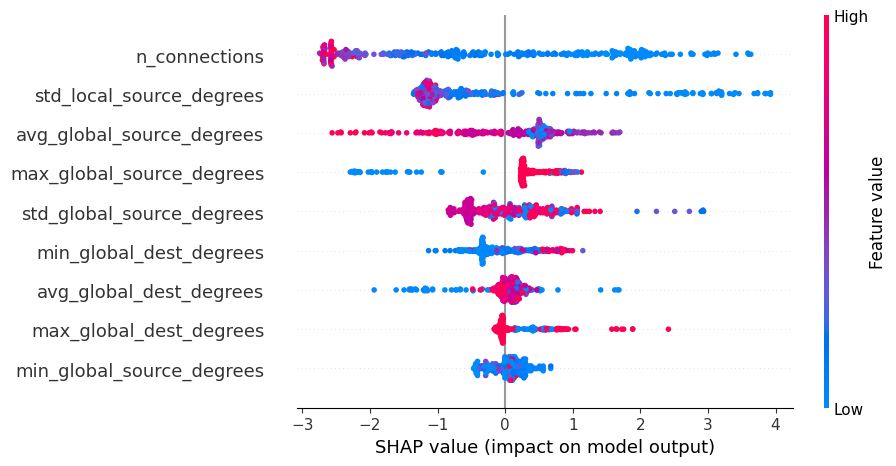

In [17]:
explainer = shap.Explainer(best_gbt)
shap_values = explainer(X_test[numerical_features].to_pandas())
shap.plots.beeswarm(shap_values)

#### False Positives & False Negatives

In [22]:
thr = 0.29
test_binary_pred = test_preds[:, 1] >= thr

fps = np.where((np.array(y_test) == False) & (test_binary_pred == True))[0]
fns = np.where((np.array(y_test) == True) & (test_binary_pred == False))[0]

print(f"There are {len(fps)} false positives")
print(f"There are {len(fns)} false negatives")

There are 16 false positives
There are 6 false negatives


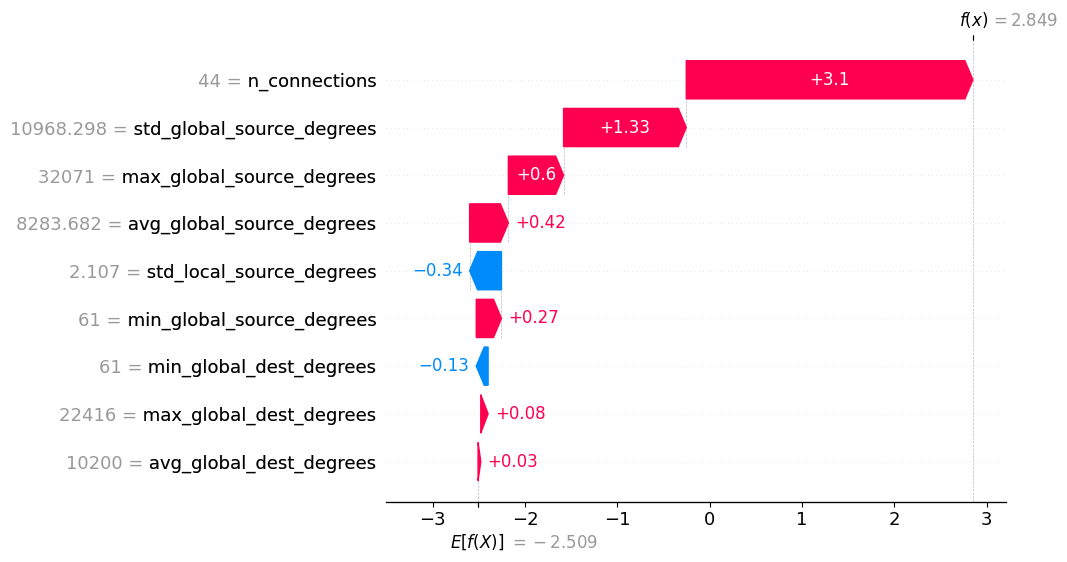

In [20]:
shap.plots.waterfall(shap_values[fps[0]])

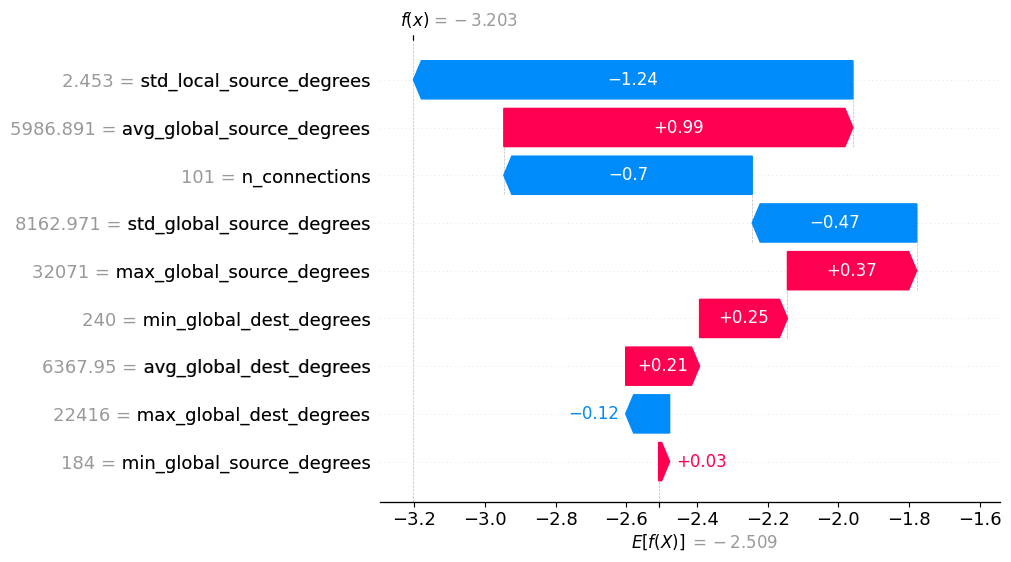

In [21]:
shap.plots.waterfall(shap_values[fns[0]])

## Save Model for Deployment

In [31]:
joblib.dump(best_gbt, '../models/hgbt_final.joblib')

['../models/hgbt_final.joblib']

## Summary

* The modelling task for anomaly detection is quite easily solved by training supervised ML model
* To make the task more challenging, only the engineered features were used to identify the anomalies
* The optimal model that was trained is HistGBT with threshold of 0.68
* The maximum F1 that can be achieved with the trained model is 0.916, which gives us a recall of 0.87 and precision 0.96
* The trained model outperforms heuristic baseline by 0.24 in terms of F1 score
* SHAP values suggest that smaller networks tend to be more anomalous